In [1]:
%matplotlib inline
import torch
from survey.utils import *
from survey.model_vae import *

In [2]:
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():

    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


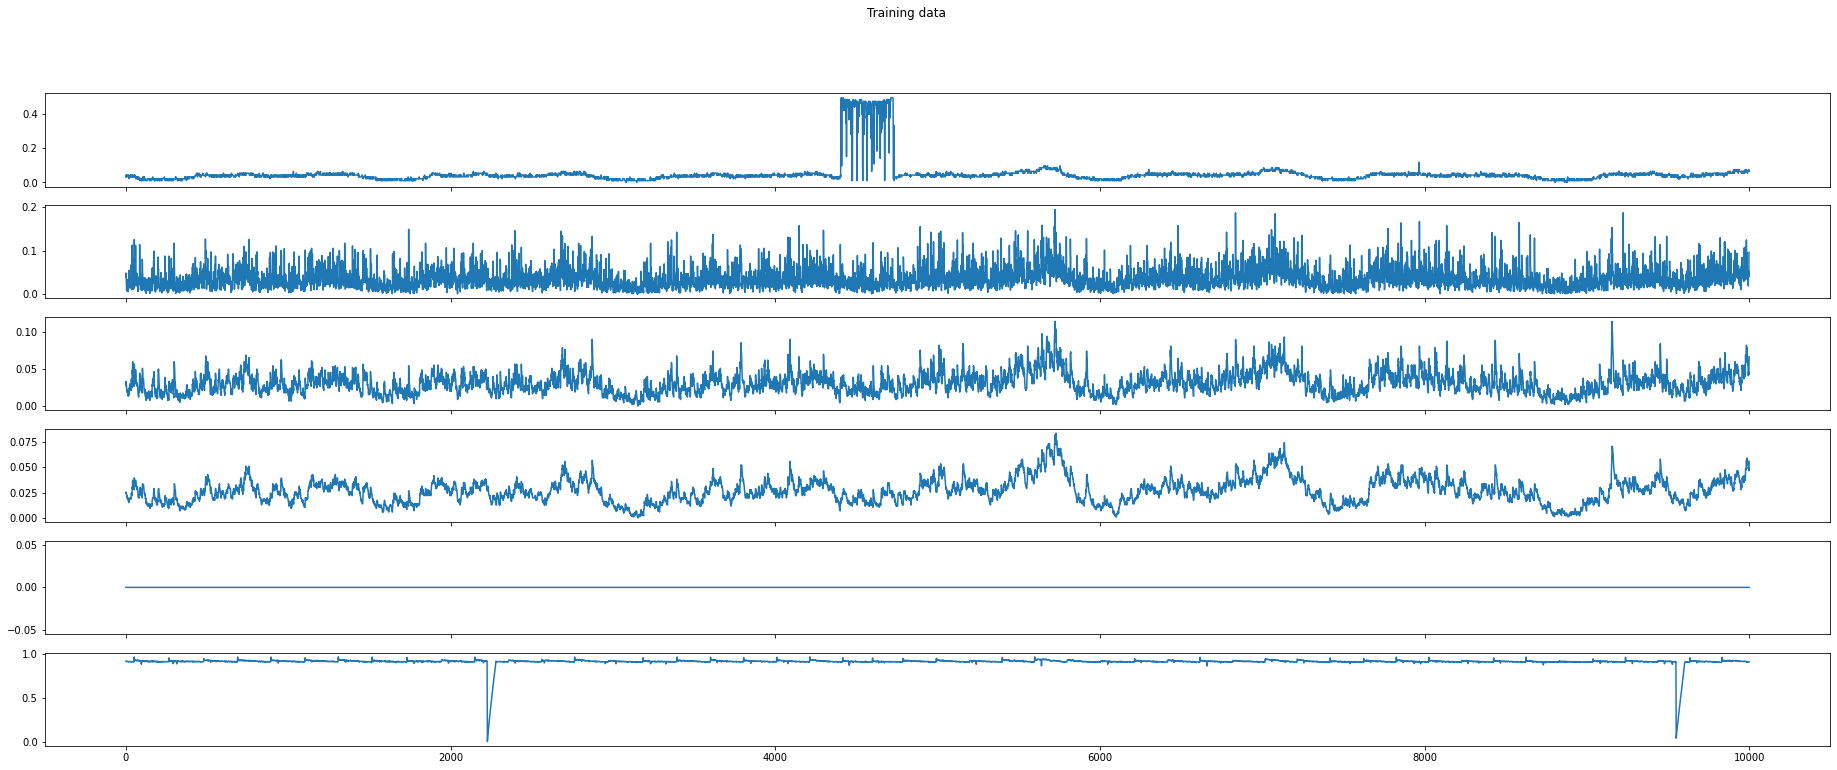

In [3]:
plot_data("machine-1-1", 10000, 6, train=True)

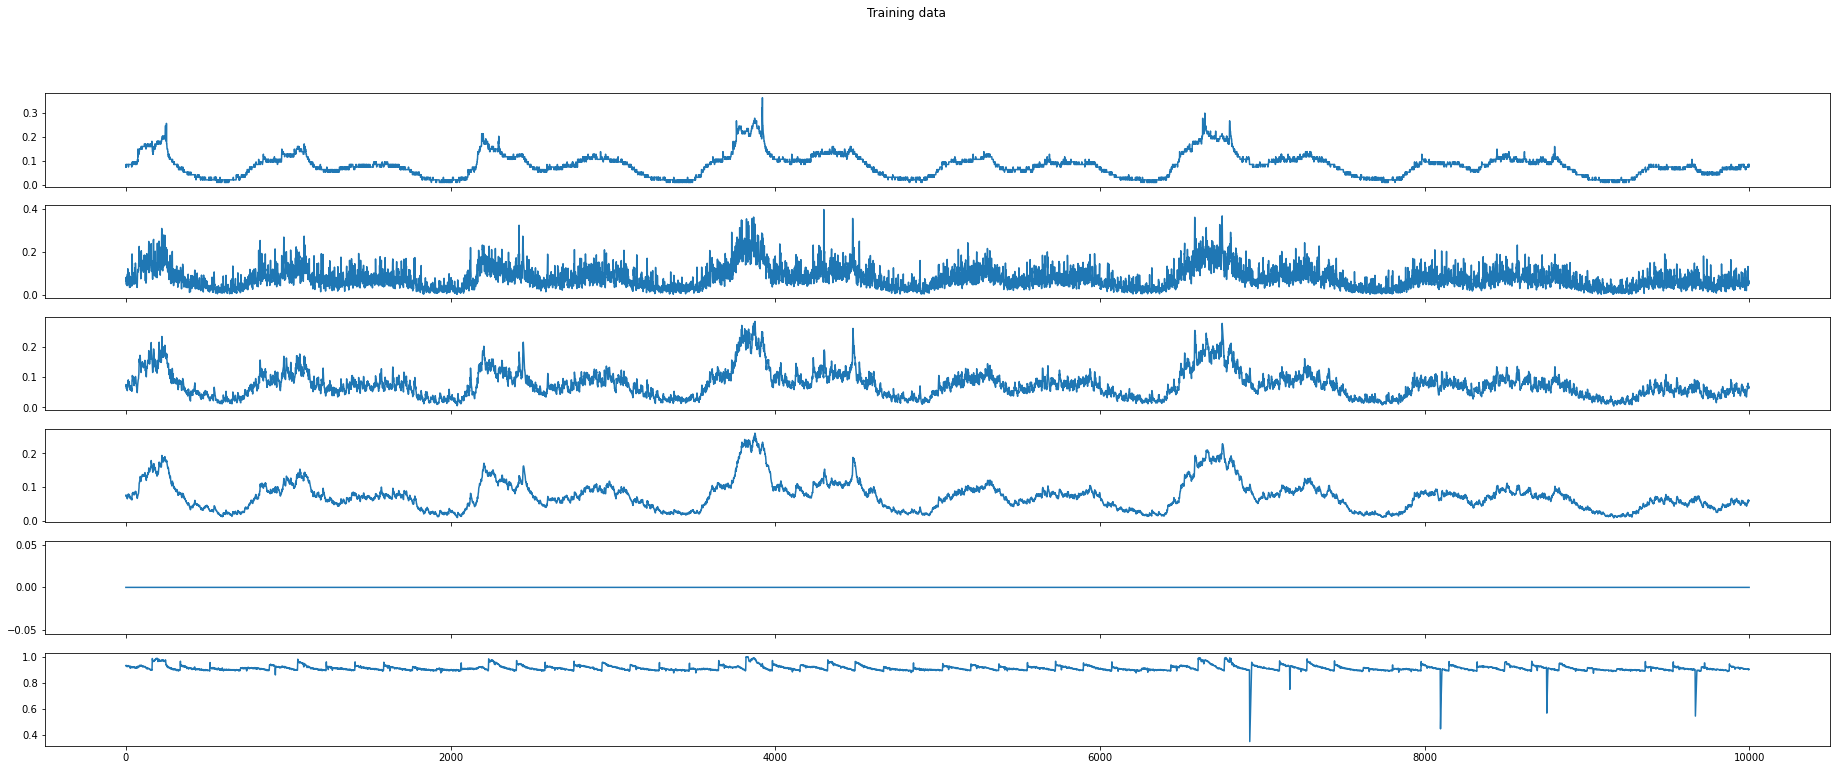

In [4]:
plot_data("machine-1-1", 10000, 6, train=False)

In [3]:
(train_data, _), ( test_data, test_label) = get_data("machine-1-1", train_end=None, train_start=0, test_start=0, test_end=None)
print('Train shape:', train_data.shape)
print('Test shape:', test_data.shape)
print('label shape:', test_label.shape)

Train shape: (28479, 38)
Test shape: (28479, 38)
label shape: (28479,)


In [5]:
# Split into sequence of length L

Total_L = train_data.shape[0]
L = 128

train_data_samples = [train_data[i*L:(i+1)*L,:8].T for i in range(int(Total_L/L))]
train_data_samples = np.stack(train_data_samples, axis=0)
test_data_samples = [test_data[i*L:(i+1)*L,:8].T for i in range(int(Total_L/L))]
test_data_samples = np.stack(test_data_samples, axis=0)
test_label_samples = [test_label[i*L:(i+1)*L].T for i in range(int(Total_L/L))]
test_label_samples = np.stack(test_label_samples, axis=0)

train = torch.tensor(train_data_samples).to(device)
test = torch.tensor(test_data_samples)#.to(device)
label = torch.tensor(test_label_samples)#.to(device)

print(train.size())
print(test.size())
print(label.size())

torch.Size([222, 8, 128])
torch.Size([222, 8, 128])
torch.Size([222, 128])


In [6]:
H = 32
C_in = 8
vae = VAE(
    N_scales=int(L/5),
    hidden_num=H,
    input_channel=C_in,
    input_length=L
)
for parameter in vae.parameters():
    nn.init.normal_(parameter, mean=0.0, std=0.01)

Kernel size:  [2, 3, 5, 7, 11, 13, 17, 19, 23]


In [7]:
def loss_fn(model, x, x_hat, muy, logvar, alpha, beta):
    reg = 0.0
    for parameter in model.parameters():
        reg += torch.sum(parameter**2)
    reconstruction_loss = torch.mean(torch.sum((x - x_hat)**2, axis=(1,2)), axis=0)
    KLD_loss = 0.5*(torch.mean(-1 + muy**2 + torch.exp(logvar) - logvar))
    loss = reconstruction_loss + alpha*KLD_loss + beta*reg
    return loss

In [8]:
batch_size = 8
epochs = 2
alpha = 1e-4
beta = 1e-4
lr=1e-2
iteration = int(train_data_samples.shape[0]/batch_size)


In [9]:
optimizer = optim.Adam(vae.parameters(), lr=lr, weight_decay=0.01)

In [10]:

loss_hist = []
vae.to(device=device)
for e in range(epochs):
    print('\nEpoch: ', e)
    for it in range(iteration):
        x = train[it*batch_size:(it+1)*batch_size,:,:]
        optimizer.zero_grad()
        x_hat, muy, logvar, _ = vae(x)
        loss = loss_fn(vae, x, x_hat, muy, logvar, alpha, beta)
        loss.backward()
        optimizer.step()
        loss_hist.append(loss.item())
        print(loss.item())


Epoch:  0
123.22877502441406
122.34862518310547
104.61127471923828
104.1729736328125
108.58258819580078
94.87421417236328
82.1655044555664
67.69334411621094
50.667118072509766
37.15887451171875
25.51993751525879
13.61340045928955
16.26556396484375
7.084126949310303
3.7228000164031982
6.088893890380859
9.162155151367188
12.046222686767578
10.558627128601074
8.363703727722168
11.127296447753906
4.385471343994141
3.4934349060058594
5.599600791931152
4.237478733062744
4.742294788360596
3.7385096549987793

Epoch:  1
5.390259265899658
3.235591411590576
7.212983131408691
3.552187204360962
9.23321533203125
1.6784582138061523
1.4163784980773926
1.0110383033752441
0.706754207611084
8.579021453857422
4.0560302734375
1.2936443090438843
6.366763114929199
1.9540832042694092
2.0118260383605957
3.3007607460021973
4.443981647491455
6.34227991104126
3.035557270050049
2.660238265991211
9.392332077026367
3.8343539237976074
2.938472270965576
8.956846237182617
4.133515357971191
4.128589630126953
4.05391454

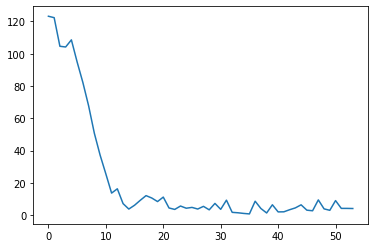

In [11]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_hist)), loss_hist)
plt.show()

In [12]:
PATH = 'result/vae.pt'
torch.save(vae, PATH)

In [10]:
PATH = 'result/vae.pt'
vae = torch.load(PATH)

In [14]:
vae.eval()
train_iteration = int(iteration/16)
x_reshape = torch.zeros((batch_size*train_iteration*L, 8))
for i in range(train_iteration):
    for j in range(batch_size):
        print(i,j)
        x_reshape[i*batch_size*L + j*L:i*batch_size*L + (j+1)*L,:] = vae(train[i*batch_size:(i+1)*batch_size,:,:])[0][j,:,:].T

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7


torch.Size([1024, 8])


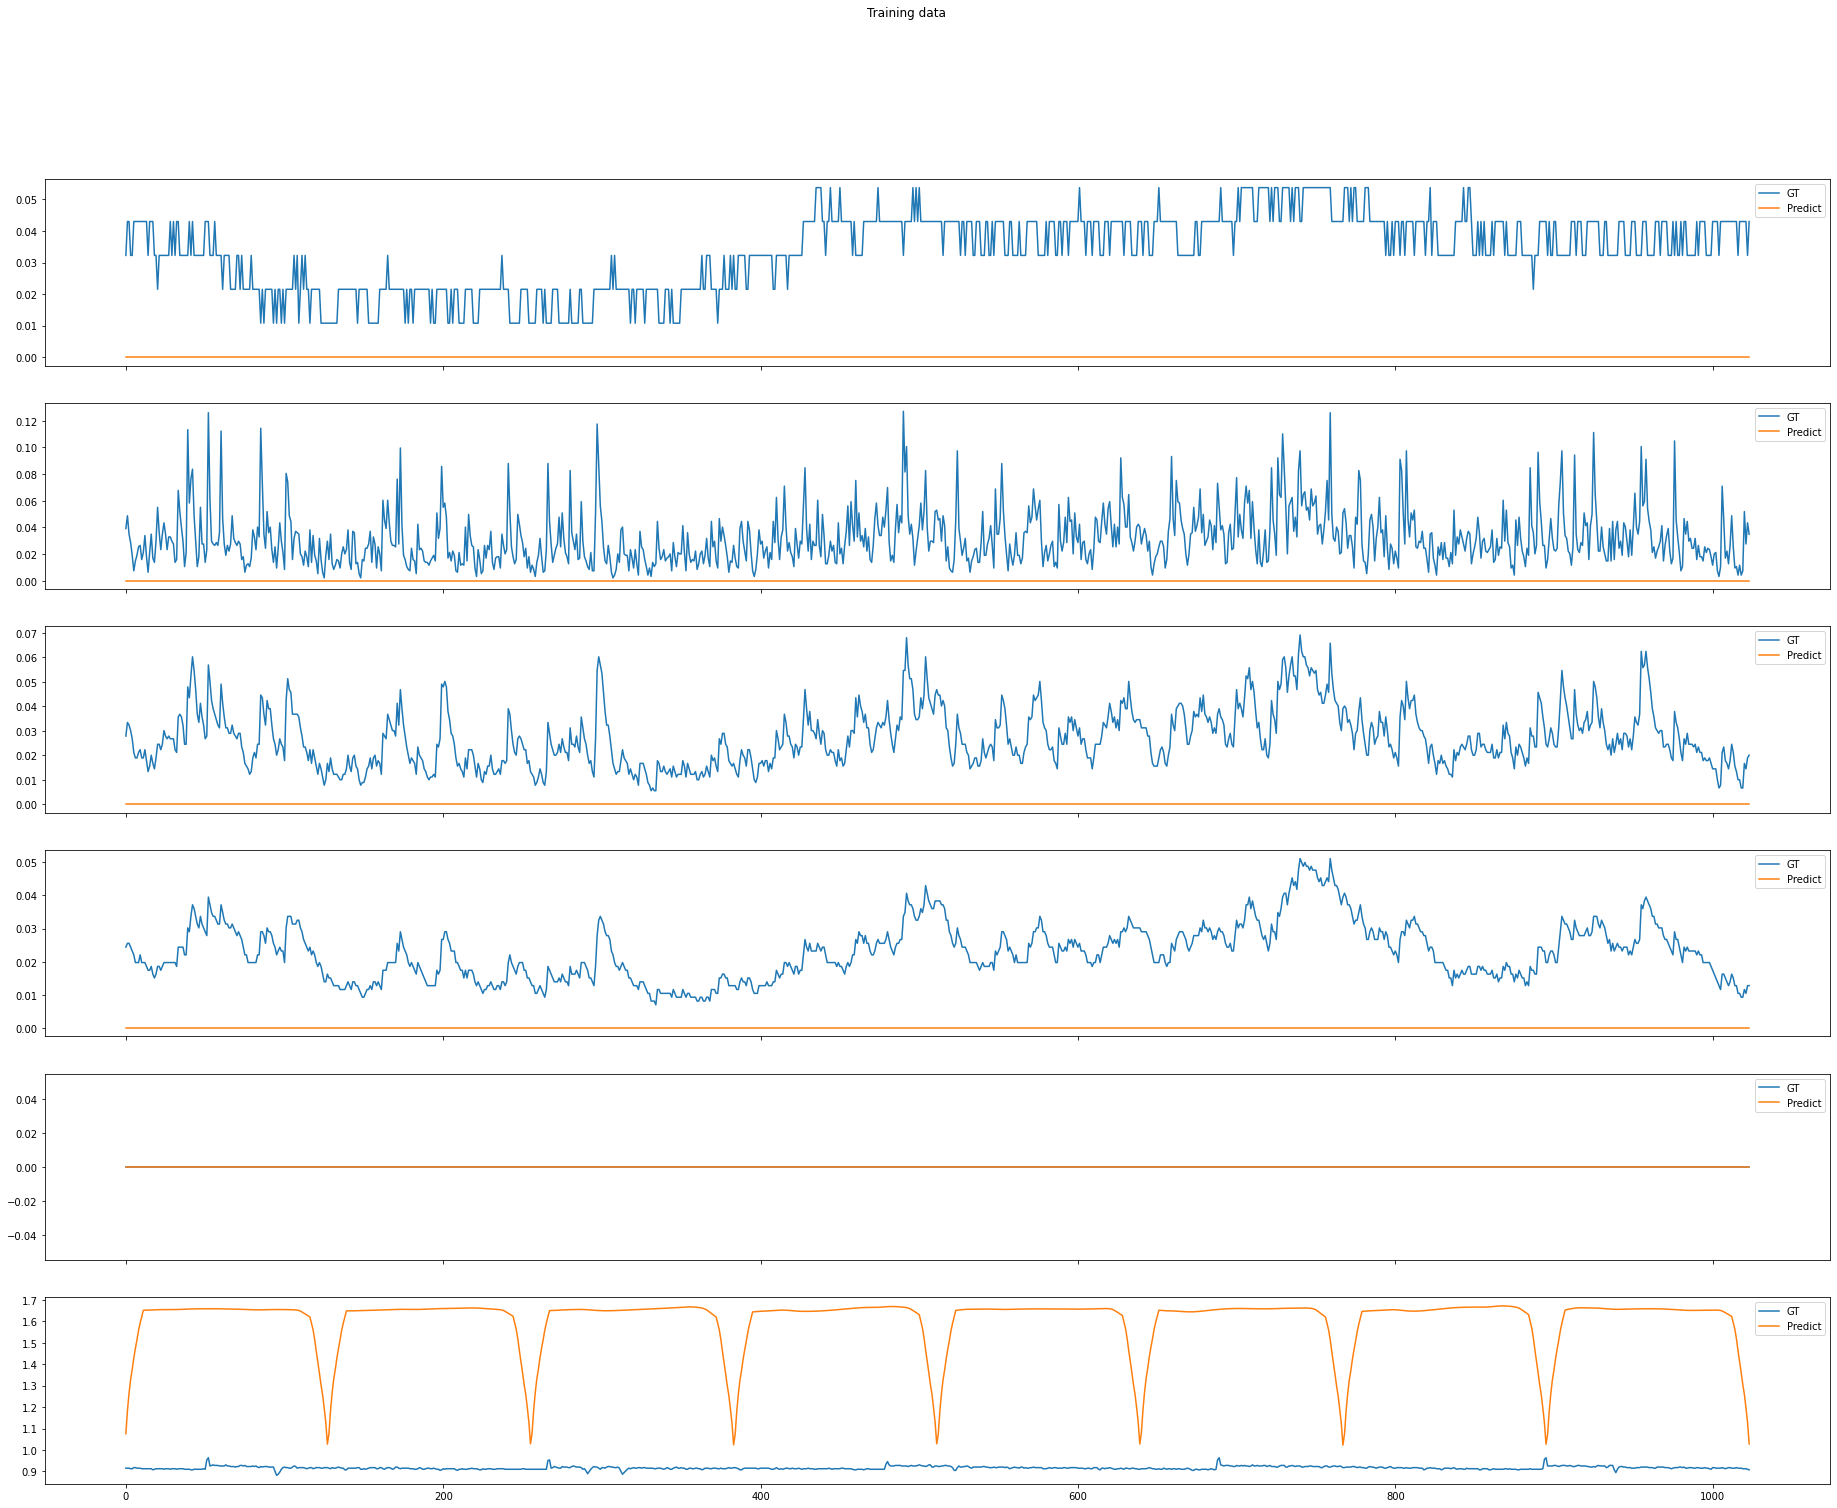

In [15]:
print(x_reshape.shape)
num_samples = batch_size*train_iteration*L

dim_list = [0,1,2,3,4,5]
num_dim = len(dim_list)
fig, (ax) = plt.subplots(num_dim, sharex=True, figsize=(32,4*num_dim))
fig.suptitle('Training data ')
for dim in range(num_dim):
    ax[dim].plot(np.arange(num_samples), train_data[0:num_samples, dim_list[dim]], label='GT')
    ax[dim].plot(np.arange(num_samples), x_reshape[0:num_samples, dim_list[dim]].detach().numpy(), label='Predict')
    ax[dim].legend()
plt.show()